### Performance of IPS's Ray-Tracing

Standard Settings are:
- test_amount=50
- step_size=10
- reflexion_order=3
- ray_scaling=True
- detail_draw=False
- output_format="channels"

Investigated Factors:
- `Ray Amount` (step_size)
- `Scaling of Rays` (ray_scaling)
- `Reflexion Order` (reflexion_order)
- `Detail Drawing of Rays` (detail_draw)

Helper:

In [6]:
import sys
sys.path += [".."] # os.path.abspath("../img-phy-sim")

import img_phy_sim as ips

import time

import numpy as np

In [7]:
def get_images(name=None, amount=1):
    dataset = ips.data.PhysGenDataset(
                        mode='train', 
                        variation="sound_reflection", 
                        input_type="osm", 
                        output_type="standard"
                    )
    
    images = []
    for cur_idx in range(amount):
        input_ = dataset[cur_idx][0].squeeze(0).numpy()  # get input image only

        if name is None:
            images += [f"./cache_img_{cur_idx}_input.png"]
        else:
            images += [name+f"_{cur_idx}.png"]
        ips.img.save(input_, images[-1], should_scale=False)

    return images

def ray_performance_test(imgs, step_size, reflexion_order, ray_scaling, detail_draw, output_format):
    test_amount = len(imgs)

    ray_compute_times = []
    ray_draw_times = []
    times = []

    for input_src in imgs:
        # input_src = get_random_image()
        input_ = ips.img.open(src=input_src, should_scale=False, should_print=False)
        
        start = time.time()
        # calc rays
        rays = ips.ray_tracing.trace_beams(rel_position=[0.5, 0.5], 
                                        img_src=input_src, 
                                        directions_in_degree=ips.math.get_linear_degree_range(step_size=step_size),
                                        wall_values=None, 
                                        wall_thickness=0,
                                        img_border_also_collide=False,
                                        reflexion_order=reflexion_order,
                                        should_scale_rays=ray_scaling,
                                        should_scale_img=False, 
                                        parallelization=-1)
        ray_compute_time = time.time() - start

        # show rays on input
        start = time.time()
        ray_img = ips.ray_tracing.draw_rays(rays, detail_draw=detail_draw, 
                                            output_format=output_format, 
                                            img_background=input_, ray_value=2, ray_thickness=1, 
                                            img_shape=(256, 256), dtype=float, standard_value=0,
                                            should_scale_rays_to_image=ray_scaling, original_max_width=None, original_max_height=None,
                                            show_only_reflections=True)
        ray_draw_time = time.time() - start

        ray_compute_times += [ray_compute_time]
        ray_draw_times += [ray_draw_time]
        times += [ray_draw_time+ray_compute_time]

    avg_time = np.mean(times)
    median_time = np.median(times)
    var_time = np.var(times)

    avg_compute_time = np.mean(ray_compute_times)
    median_compute_time = np.median(ray_compute_times)
    var_compute_time = np.var(ray_compute_times)

    avg_draw_time = np.mean(ray_draw_times)
    median_draw_time = np.median(ray_draw_times)
    var_draw_time = np.var(ray_draw_times)

    print_str = f"\n{'-'*2}\nPerformance Result with {test_amount} Tests\n"
    print_str += f"Total Time:\n    Mean = {avg_time}\n    Median = {median_time}\n    Variance = {var_time}"
    print_str += f"\n\nRay Compute Time:\n    Mean = {avg_compute_time}\n    Median = {median_compute_time}\n    Variance = {var_compute_time}"
    print_str += f"\n\nRay Draw Time:\n    Mean = {avg_draw_time}\n    Median = {median_draw_time}\n    Variance = {var_draw_time}"

    print(print_str)

    return [
        avg_time,
        median_time,
        var_time,
        avg_compute_time,
        median_compute_time,
        var_compute_time,
        avg_draw_time,
        median_draw_time,
        var_draw_time,
    ]

def compare_results(results):
    results = np.array(results)
    num_experiments = len(results)

    metrics = [
        "avg_time", "median_time", "var_time",
        "avg_compute_time", "median_compute_time", "var_compute_time",
        "avg_draw_time", "median_draw_time", "var_draw_time"
    ]

    summary = f"\nNumber of experiments: {num_experiments}\n"

    # Analyze each metric
    for i, name in enumerate(metrics):
        values = results[:, i]

        mean_val = np.mean(values)
        std_val = np.std(values)
        min_val = np.min(values)
        max_val = np.max(values)
        rel_change = (max_val - min_val) / mean_val * 100 if mean_val != 0 else 0

        summary += f"\n\
            {name:20s}: mean={mean_val:.4f}, std={std_val:.4f}, min={min_val:.4f}, max={max_val:.4f}, rel_change={rel_change:.2f}%"

    # Check overall trend in avg_time
    avg_times = results[:, 0]
    trend = np.polyfit(np.arange(num_experiments), avg_times, 1)[0]
    if trend > 0:
        trend_desc = "increasing"
    elif trend < 0:
        trend_desc = "decreasing"
    else:
        trend_desc = "stable"

    summary += f"\n\nOverall trend in avg_time: {trend_desc} ({trend:.4e} change per experiment)"
    summary += f"\nConclusion: Performance changes {('significantly' if np.std(avg_times) / np.mean(avg_times) > 0.1 else 'slightly')} across experiments."

    print(summary)

    return summary

In [ ]:
imgs = get_images(name=None, amount=50)

PhysGen (sound_reflection) Dataset for train got created


Loaded Image:
    - Image size: 256x256
    - Bit depth: 8-bit
    - Dtype: uint8


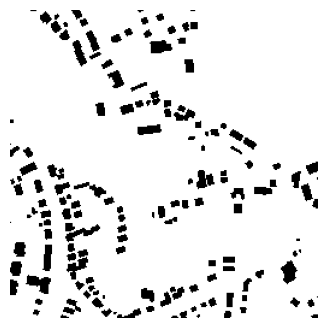

In [9]:
ips.img.imshow(ips.img.open(imgs[0]), size=4)

**Experiment 1: Ray Amount**

In [10]:
results = []
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=3, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]

d:\Programme\Anaconda\envs\img-phy-sim\Lib\site-packages\numpy\_core\numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')



--
Performance Result with 50 Tests
Total Time:
    Mean = 0.8002555894851685
    Median = 0.43300092220306396
    Variance = 5.027940077049426

Ray Compute Time:
    Mean = 0.7745464849472046
    Median = 0.4083777666091919
    Variance = 5.026419254402238

Ray Draw Time:
    Mean = 0.025709104537963868
    Median = 0.025001883506774902
    Variance = 7.004348296959507e-06


In [11]:
results += [ray_performance_test(imgs=imgs, 
                                step_size=5, 
                                reflexion_order=3, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 0.7900977802276611
    Median = 0.7412127256393433
    Variance = 0.05710821391876389

Ray Compute Time:
    Mean = 0.7348810720443726
    Median = 0.6871386766433716
    Variance = 0.05564845165048357

Ray Draw Time:
    Mean = 0.055216708183288575
    Median = 0.05432391166687012
    Variance = 4.283285218573384e-05


In [12]:
results += [ray_performance_test(imgs=imgs, 
                                step_size=1, 
                                reflexion_order=3, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 3.0742918920516966
    Median = 2.7769912481307983
    Variance = 0.6795907473774929

Ray Compute Time:
    Mean = 2.8119481420516967
    Median = 2.520076632499695
    Variance = 0.6469772924705868

Ray Draw Time:
    Mean = 0.26234375
    Median = 0.25439584255218506
    Variance = 0.0008107272780856875


In [13]:
results += [ray_performance_test(imgs=imgs, 
                                step_size=0.1, 
                                reflexion_order=3, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 30.766451535224913
    Median = 28.403717279434204
    Variance = 53.311853062595326

Ray Compute Time:
    Mean = 26.713534898757935
    Median = 24.952489733695984
    Variance = 46.40694797051054

Ray Draw Time:
    Mean = 4.05291663646698
    Median = 3.8211551904678345
    Variance = 1.1372222594003103


In [14]:
compare_results(results);


Number of experiments: 4

            avg_time            : mean=8.8578, std=12.6832, min=0.7901, max=30.7665, rel_change=338.42%
            median_time         : mean=8.0887, std=11.7634, min=0.4330, max=28.4037, rel_change=345.80%
            var_time            : mean=14.7691, std=22.3349, min=0.0571, max=53.3119, rel_change=360.58%
            avg_compute_time    : mean=7.7587, std=10.9758, min=0.7349, max=26.7135, rel_change=334.83%
            median_compute_time : mean=7.1420, std=10.3148, min=0.4084, max=24.9525, rel_change=343.66%
            var_compute_time    : mean=13.0340, std=19.3633, min=0.0556, max=46.4069, rel_change=355.62%
            avg_draw_time       : mean=1.0990, std=1.7079, min=0.0257, max=4.0529, rel_change=366.43%
            median_draw_time    : mean=1.0387, std=1.6089, min=0.0250, max=3.8212, rel_change=365.46%
            var_draw_time       : mean=0.2845, std=0.4923, min=0.0000, max=1.1372, rel_change=399.70%

Overall trend in avg_time: increasing (9

**Experiment 2: Ray Scaling**

In [15]:
results = []
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=3, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 0.4708528995513916
    Median = 0.4316222667694092
    Variance = 0.038702712745759975

Ray Compute Time:
    Mean = 0.4450233840942383
    Median = 0.4063795804977417
    Variance = 0.038106329927588285

Ray Draw Time:
    Mean = 0.02582951545715332
    Median = 0.025360107421875
    Variance = 4.460550236126437e-06


In [16]:
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=3, 
                                ray_scaling=False, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 0.44871781826019286
    Median = 0.39867842197418213
    Variance = 0.036358520748447996

Ray Compute Time:
    Mean = 0.4375401830673218
    Median = 0.3883950710296631
    Variance = 0.036140352314403594

Ray Draw Time:
    Mean = 0.011177635192871094
    Median = 0.010463356971740723
    Variance = 3.594583479298308e-06


In [17]:
compare_results(results);


Number of experiments: 2

            avg_time            : mean=0.4598, std=0.0111, min=0.4487, max=0.4709, rel_change=4.81%
            median_time         : mean=0.4152, std=0.0165, min=0.3987, max=0.4316, rel_change=7.94%
            var_time            : mean=0.0375, std=0.0012, min=0.0364, max=0.0387, rel_change=6.25%
            avg_compute_time    : mean=0.4413, std=0.0037, min=0.4375, max=0.4450, rel_change=1.70%
            median_compute_time : mean=0.3974, std=0.0090, min=0.3884, max=0.4064, rel_change=4.53%
            var_compute_time    : mean=0.0371, std=0.0010, min=0.0361, max=0.0381, rel_change=5.30%
            avg_draw_time       : mean=0.0185, std=0.0073, min=0.0112, max=0.0258, rel_change=79.18%
            median_draw_time    : mean=0.0179, std=0.0074, min=0.0105, max=0.0254, rel_change=83.17%
            var_draw_time       : mean=0.0000, std=0.0000, min=0.0000, max=0.0000, rel_change=21.50%

Overall trend in avg_time: decreasing (-2.2135e-02 change per experim

**Experiment 3: Reflexion Order**

In [18]:
results = []
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=0, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 0.16789505004882813
    Median = 0.16629457473754883
    Variance = 0.000926604810103163

Ray Compute Time:
    Mean = 0.1511699628829956
    Median = 0.14943528175354004
    Variance = 0.000824603481485815

Ray Draw Time:
    Mean = 0.01672508716583252
    Median = 0.016928911209106445
    Variance = 3.7541688931241874e-06


In [19]:
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=1, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 0.31716706275939943
    Median = 0.30970585346221924
    Variance = 0.0065866186597664635

Ray Compute Time:
    Mean = 0.29563138008117673
    Median = 0.28924477100372314
    Variance = 0.006431432757523543

Ray Draw Time:
    Mean = 0.021535682678222656
    Median = 0.02170717716217041
    Variance = 2.3353529286396226e-06


In [20]:
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=2, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 0.40976503372192385
    Median = 0.38941681385040283
    Variance = 0.01787797197657401

Ray Compute Time:
    Mean = 0.3859426736831665
    Median = 0.3647562265396118
    Variance = 0.017568673013661853

Ray Draw Time:
    Mean = 0.023822360038757324
    Median = 0.02359461784362793
    Variance = 2.7882689193802433e-06


In [21]:
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=4, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 0.5526896905899048
    Median = 0.459814190864563
    Variance = 0.09887934966135183

Ray Compute Time:
    Mean = 0.5249349021911621
    Median = 0.43258488178253174
    Variance = 0.09756507116900175

Ray Draw Time:
    Mean = 0.027754788398742677
    Median = 0.027002573013305664
    Variance = 1.0270676915502008e-05


In [22]:
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=16, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 1.8009302425384521
    Median = 0.521742582321167
    Variance = 20.563186930084388

Ray Compute Time:
    Mean = 1.7559777545928954
    Median = 0.4830052852630615
    Variance = 20.49508431468224

Ray Draw Time:
    Mean = 0.04495248794555664
    Median = 0.04294288158416748
    Variance = 0.0001748568374705428


In [25]:
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=64, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 21.227636489868164
    Median = 0.8549197912216187
    Variance = 5265.157726257308

Ray Compute Time:
    Mean = 21.116943316459654
    Median = 0.7187716960906982
    Variance = 5261.7530683421755

Ray Draw Time:
    Mean = 0.1106931734085083
    Median = 0.10016334056854248
    Variance = 0.002757002254763142


In [26]:
compare_results(results);


Number of experiments: 6

            avg_time            : mean=4.0793, std=7.6878, min=0.1679, max=21.2276, rel_change=516.25%
            median_time         : mean=0.4503, std=0.2133, min=0.1663, max=0.8549, rel_change=152.92%
            var_time            : mean=880.9742, std=1960.6808, min=0.0009, max=5265.1577, rel_change=597.65%
            avg_compute_time    : mean=4.0384, std=7.6560, min=0.1512, max=21.1169, rel_change=519.16%
            median_compute_time : mean=0.4063, std=0.1759, min=0.1494, max=0.7188, rel_change=140.13%
            var_compute_time    : mean=880.3951, std=1959.4171, min=0.0008, max=5261.7531, rel_change=597.66%
            avg_draw_time       : mean=0.0409, std=0.0324, min=0.0167, max=0.1107, rel_change=229.67%
            median_draw_time    : mean=0.0387, std=0.0286, min=0.0169, max=0.1002, rel_change=214.95%
            var_draw_time       : mean=0.0005, std=0.0010, min=0.0000, max=0.0028, rel_change=560.08%

Overall trend in avg_time: increasin

**Experiment 4: Detail Draw**

In [27]:
results = []
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=3, 
                                ray_scaling=True, 
                                detail_draw=False, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 0.46007269382476806
    Median = 0.4204148054122925
    Variance = 0.0378306461163261

Ray Compute Time:
    Mean = 0.4346325397491455
    Median = 0.3959465026855469
    Variance = 0.037229954185788755

Ray Draw Time:
    Mean = 0.02544015407562256
    Median = 0.02491593360900879
    Variance = 4.1167902686765955e-06


In [28]:
results += [ray_performance_test(imgs=imgs, 
                                step_size=10, 
                                reflexion_order=3, 
                                ray_scaling=True, 
                                detail_draw=True, 
                                output_format="channels")]


--
Performance Result with 50 Tests
Total Time:
    Mean = 0.6104308557510376
    Median = 0.5624738931655884
    Variance = 0.054604870289172346

Ray Compute Time:
    Mean = 0.4307444715499878
    Median = 0.3920600414276123
    Variance = 0.036037113721256016

Ray Draw Time:
    Mean = 0.1796863842010498
    Median = 0.1716548204421997
    Variance = 0.003578455135592412


In [29]:
compare_results(results);


Number of experiments: 2

            avg_time            : mean=0.5353, std=0.0752, min=0.4601, max=0.6104, rel_change=28.09%
            median_time         : mean=0.4914, std=0.0710, min=0.4204, max=0.5625, rel_change=28.91%
            var_time            : mean=0.0462, std=0.0084, min=0.0378, max=0.0546, rel_change=36.29%
            avg_compute_time    : mean=0.4327, std=0.0019, min=0.4307, max=0.4346, rel_change=0.90%
            median_compute_time : mean=0.3940, std=0.0019, min=0.3921, max=0.3959, rel_change=0.99%
            var_compute_time    : mean=0.0366, std=0.0006, min=0.0360, max=0.0372, rel_change=3.26%
            avg_draw_time       : mean=0.1026, std=0.0771, min=0.0254, max=0.1797, rel_change=150.39%
            median_draw_time    : mean=0.0983, std=0.0734, min=0.0249, max=0.1717, rel_change=149.30%
            var_draw_time       : mean=0.0018, std=0.0018, min=0.0000, max=0.0036, rel_change=199.54%

Overall trend in avg_time: increasing (1.5036e-01 change per ex

<br><br>

**All Results**

Executed with 50 random images.


<br><br>

Experiment 1: Ray Amount

```text
Number of experiments: 4

            avg_time            : mean=8.8578, std=12.6832, min=0.7901, max=30.7665, rel_change=338.42%
            median_time         : mean=8.0887, std=11.7634, min=0.4330, max=28.4037, rel_change=345.80%
            var_time            : mean=14.7691, std=22.3349, min=0.0571, max=53.3119, rel_change=360.58%
            avg_compute_time    : mean=7.7587, std=10.9758, min=0.7349, max=26.7135, rel_change=334.83%
            median_compute_time : mean=7.1420, std=10.3148, min=0.4084, max=24.9525, rel_change=343.66%
            var_compute_time    : mean=13.0340, std=19.3633, min=0.0556, max=46.4069, rel_change=355.62%
            avg_draw_time       : mean=1.0990, std=1.7079, min=0.0257, max=4.0529, rel_change=366.43%
            median_draw_time    : mean=1.0387, std=1.6089, min=0.0250, max=3.8212, rel_change=365.46%
            var_draw_time       : mean=0.2845, std=0.4923, min=0.0000, max=1.1372, rel_change=399.70%

Overall trend in avg_time: increasing (9.2183e+00 change per experiment)
Conclusion: Performance changes significantly across experiments.
```


<br><br>

Experiment 2: Ray Scaling

```text
Number of experiments: 2

            avg_time            : mean=0.4598, std=0.0111, min=0.4487, max=0.4709, rel_change=4.81%
            median_time         : mean=0.4152, std=0.0165, min=0.3987, max=0.4316, rel_change=7.94%
            var_time            : mean=0.0375, std=0.0012, min=0.0364, max=0.0387, rel_change=6.25%
            avg_compute_time    : mean=0.4413, std=0.0037, min=0.4375, max=0.4450, rel_change=1.70%
            median_compute_time : mean=0.3974, std=0.0090, min=0.3884, max=0.4064, rel_change=4.53%
            var_compute_time    : mean=0.0371, std=0.0010, min=0.0361, max=0.0381, rel_change=5.30%
            avg_draw_time       : mean=0.0185, std=0.0073, min=0.0112, max=0.0258, rel_change=79.18%
            median_draw_time    : mean=0.0179, std=0.0074, min=0.0105, max=0.0254, rel_change=83.17%
            var_draw_time       : mean=0.0000, std=0.0000, min=0.0000, max=0.0000, rel_change=21.50%

Overall trend in avg_time: decreasing (-2.2135e-02 change per experiment)
Conclusion: Performance changes slightly across experiments.
```

<br><br>

Experiment 3: Reflexion Order

```text
Number of experiments: 6

            avg_time            : mean=4.0793, std=7.6878, min=0.1679, max=21.2276, rel_change=516.25%
            median_time         : mean=0.4503, std=0.2133, min=0.1663, max=0.8549, rel_change=152.92%
            var_time            : mean=880.9742, std=1960.6808, min=0.0009, max=5265.1577, rel_change=597.65%
            avg_compute_time    : mean=4.0384, std=7.6560, min=0.1512, max=21.1169, rel_change=519.16%
            median_compute_time : mean=0.4063, std=0.1759, min=0.1494, max=0.7188, rel_change=140.13%
            var_compute_time    : mean=880.3951, std=1959.4171, min=0.0008, max=5261.7531, rel_change=597.66%
            avg_draw_time       : mean=0.0409, std=0.0324, min=0.0167, max=0.1107, rel_change=229.67%
            median_draw_time    : mean=0.0387, std=0.0286, min=0.0169, max=0.1002, rel_change=214.95%
            var_draw_time       : mean=0.0005, std=0.0010, min=0.0000, max=0.0028, rel_change=560.08%

Overall trend in avg_time: increasing (3.1398e+00 change per experiment)
Conclusion: Performance changes significantly across experiments.
```

<br><br>

Experiment 4: Detail Draw

```text
Number of experiments: 2

            avg_time            : mean=0.5353, std=0.0752, min=0.4601, max=0.6104, rel_change=28.09%
            median_time         : mean=0.4914, std=0.0710, min=0.4204, max=0.5625, rel_change=28.91%
            var_time            : mean=0.0462, std=0.0084, min=0.0378, max=0.0546, rel_change=36.29%
            avg_compute_time    : mean=0.4327, std=0.0019, min=0.4307, max=0.4346, rel_change=0.90%
            median_compute_time : mean=0.3940, std=0.0019, min=0.3921, max=0.3959, rel_change=0.99%
            var_compute_time    : mean=0.0366, std=0.0006, min=0.0360, max=0.0372, rel_change=3.26%
            avg_draw_time       : mean=0.1026, std=0.0771, min=0.0254, max=0.1797, rel_change=150.39%
            median_draw_time    : mean=0.0983, std=0.0734, min=0.0249, max=0.1717, rel_change=149.30%
            var_draw_time       : mean=0.0018, std=0.0018, min=0.0000, max=0.0036, rel_change=199.54%

Overall trend in avg_time: increasing (1.5036e-01 change per experiment)
Conclusion: Performance changes significantly across experiments.
```

<br><br>

Summary:

The Stepsize/amount of rays have the biggest impact on the performance. The other parameters have rather a small impact.

In [30]:
# cleanup
import os
for img in imgs:
    os.remove(img)